# Basic Walkthrough - Gaussian Regression

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/docs/examples/Gaussian_Regression.ipynb)

In this example, we model and predict all parameters of a univariate Normal distribution. Recall that distributional regression models and predicts all parameters $\theta_{ik}, k=1, \ldots, K$ parameters of a distribution $\mathcal{D}$ as a function of covariates:

\begin{equation}
y_{i} \stackrel{ind}{\sim} \mathcal{D}
  \begin{pmatrix}
     h_{1}\bigl(\theta_{i1}(x_{i})\bigr) = \eta_{i1} \\
    h_{2}\bigl(\theta_{i2}(x_{i})\bigr) = \eta_{i2}  \\
	\vdots \\                        
	h_{K}\bigl(\theta_{iK}(x_{i})\bigr) = \eta_{iK}
\end{pmatrix}
\quad ,i=1, \ldots, N.
\end{equation}

where $h_{k}(\cdot)$ transforms each distributional parameter to the corresponding parameter scale. For the univariate Normal case, we can specify the above as $y_{i} \stackrel{ind}{\sim} \mathcal{N}\bigl(\mu_{i}(x_{i}), \sigma_{i}(x_{i})\bigr)$. Since $\mu_{i}(\cdot) \in \mathbb{R}$ and since the standard-deviation cannot be negative, $h_{k}(\cdot)$ is applied to $\sigma_{i}(\cdot)$ only. Typical choices are the exponential or the softplus function.

# Imports

First, we import the necessary functions.

In [249]:
!pip install mlforecast

In [250]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *
from lightgbmlss.datasets.data_loader import load_simulated_gaussian_data
from scipy.stats import norm

import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)

# Data

The data is simulated as a Gaussian, where $x_{true}$ is the only true feature and all others are noise variables:
- $\mu(x_{true}) = 10$
- $\sigma(x_{true}) = 1 + 4 * \bigr((0.3 < x_{true}) \& (x_{true} < 0.5)\bigl) + 2 * (x_{true} > 0.7)$

We first load the simulated dataset, filter for the target and covariates and then create the `lgb.Dataset`. LightGBMLSS is designed to closely resemble the usage of LightGBM, ensuring ease of adoption and full compatibility.

In [296]:
class MyLGBMLSS(LightGBMLSS):
    def __init__(self,dist,params = None):
        super().__init__(dist)
        self.params = params if params is not None else {}

    def fit(self, X, y, **kwargs):
        """Fits the model using the provided data.

        Args:
            X: The training data.
            y: The target variable.
            **kwargs: Additional arguments to pass to the 'train' method.
        """
        train_set = lgb.Dataset(data=X, label=y)  # Create lgb.Dataset
        self.train(params = self.params,train_set=train_set, **kwargs)  # Call the original 'train' method

    def predict(self, X, **kwargs):
        """Predicts using the fitted model.

        Args:
            X: The input data for prediction.
            **kwargs: Additional arguments to pass to the 'predict' method.

        Returns:
            The predictions.
        """
        # Access the original 'predict' method using super() # take first column (rate or loc)
        predictions = super().predict(X, **kwargs).iloc[:,0].values.ravel()

        # Add custom logic here to modify predictions
        # Example: Convert raw predictions to probabilities for classification
        # predictions = 1 / (1 + np.exp(-predictions))  # Sigmoid for probabilities

        return predictions  # Return the modified predictions


    def get_params(self, deep=True):
      """Gets parameters for this estimator.

      Args:
        deep (bool, optional): If True, will return the parameters for this estimator and
            contained subobjects that are estimators. Defaults to True.

      Returns:
        dict: Parameter names mapped to their values.
      """
      params = {'dist': self.dist, 'params': self.params}
      return params

Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


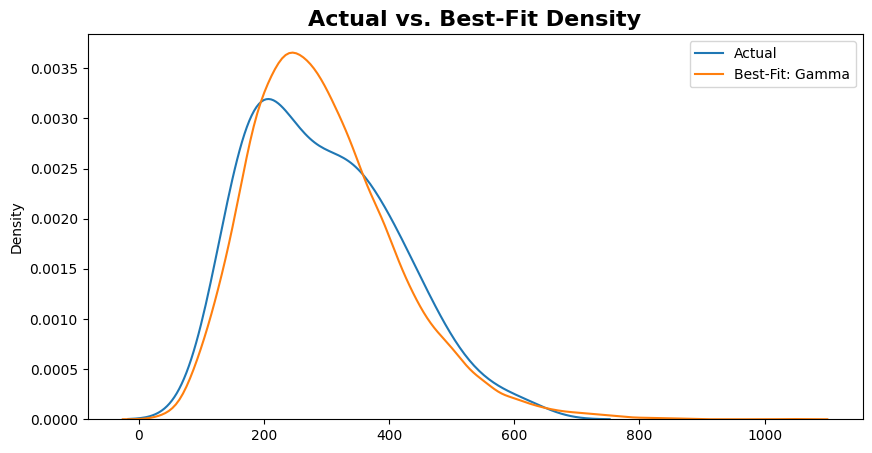

,nll,distribution
rank,,
1,806.518066,Gamma
2,806.682251,LogNormal
3,807.488831,Gumbel
4,809.940369,Weibull
5,813.679749,Gaussian
6,825.331482,Laplace
7,843.473389,Cauchy
8,944.215576,StudentT


In [297]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
from sklearn import datasets
from sklearn.model_selection import train_test_split

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

dist_nll = lgblss_dist_class.dist_select(target=y, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(10, 5))
dist_nll

In [320]:
import pandas as pd
from mlforecast import MLForecast
import lightgbm as lgb

df = pd.read_csv("https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv",parse_dates = ['ds'])

mlf = MLForecast(models = {'norm_lgb':lgb.LGBMRegressor(verbosity=-1)}, freq = 'MS',
                 date_features=['month','quarter'],
                 lags = [1,2,3,4,5,6,7,8,9,10,11,12])

X, y = mlf.preprocess(df,return_X_y = True)

In [321]:
model = MyLGBMLSS(dist = Gaussian.Gaussian(),params = {'eta':.15,'max_depth':-1})

model.fit(X,y)

model.predict(X)

array([171.10739, 171.10739, 171.88264, 171.88264, 171.35146, 174.12459,
       174.16943, 174.16943, 169.22168, 169.22168, 169.22168, 169.22168,
       171.10739, 171.10739, 171.88264, 171.88264, 171.35146, 182.87471,
       194.63774, 196.3085 , 181.36627, 171.32764, 171.43176, 168.06   ,
       169.7416 , 180.13977, 190.09079, 180.89908, 188.80606, 208.6901 ,
       227.50809, 235.92853, 217.26495, 187.7434 , 170.07333, 179.0774 ,
       204.05502, 218.45697, 223.86804, 232.50258, 230.28731, 242.58977,
       264.04272, 271.9928 , 240.60307, 216.43372, 213.52399, 216.80406,
       221.80084, 216.34442, 247.12575, 262.72778, 245.00523, 284.33258,
       297.8281 , 293.05566, 262.72333, 243.45233, 234.69319, 230.68465,
       243.78284, 233.20665, 265.9116 , 268.82556, 270.0397 , 311.0863 ,
       333.726  , 336.02872, 307.5113 , 269.68304, 248.09473, 277.175  ,
       283.9976 , 276.99734, 316.9932 , 312.99084, 317.81445, 357.7869 ,
       417.5307 , 386.92444, 359.32434, 305.91882, 

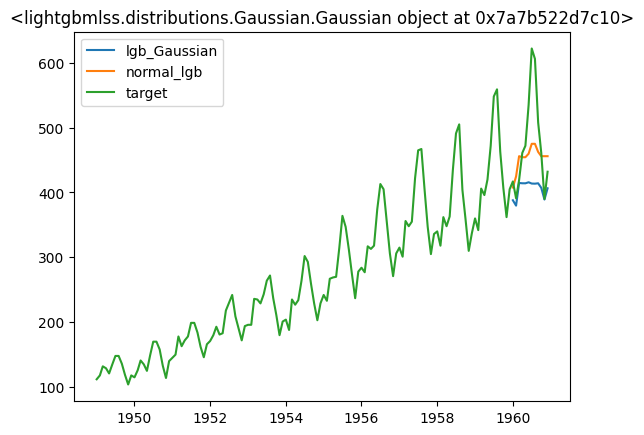

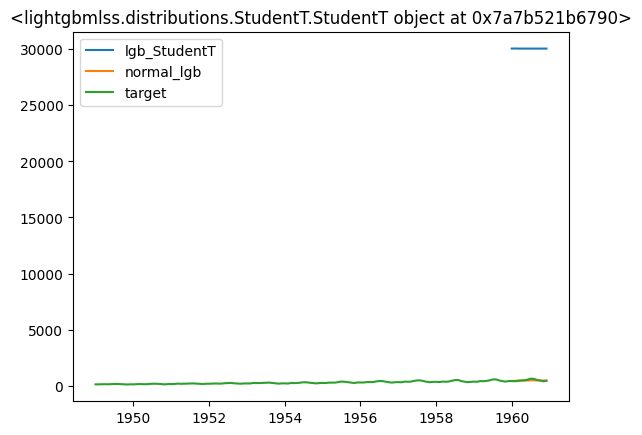

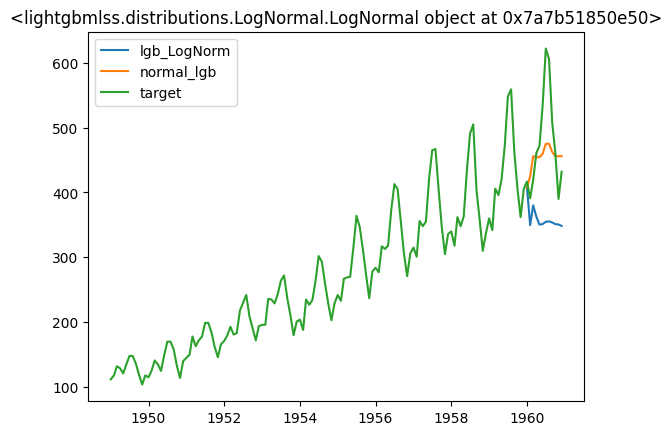

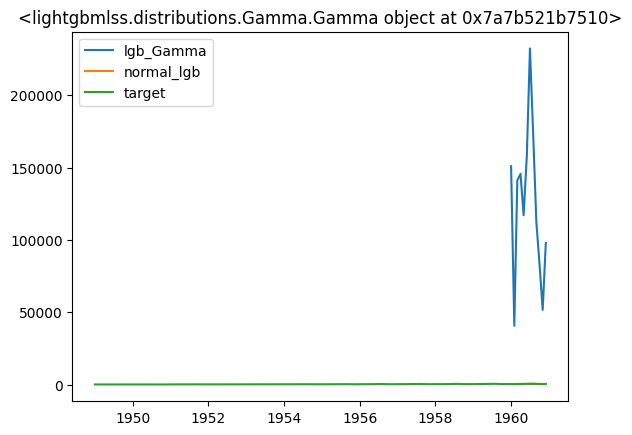

In [330]:
from lightgbmlss.model import LightGBMLSS  # Assuming necessary imports
import matplotlib.pyplot as plt


dists = dict(zip(['Gaussian',
                  'StudentT',
                  'LogNorm',
                  'Gamma'],
                    [Gaussian.Gaussian(),
                     StudentT.StudentT(),
                     LogNormal.LogNormal(),
                     Gamma.Gamma()]
))

for name, distribution in dists.items():

  model = MyLGBMLSS(dist = distribution,params = {'eta':.15,
                                                  'max_depth':-1,
                                                  'n_estimators':100})
  # fit to X,y
  model.fit(X,y)

  mlf.fit(df = df.iloc[:-12])

  mlf.models_['lgbmlss'] = model
  preds = mlf.predict(h = 12)

  if name in ['Gamma','LogNorm']:
    preds.lgbmlss = preds.lgbmlss.apply(lambda x: np.exp(x))

  plt.plot(df.ds[-12:],preds.lgbmlss,label=f'lgb_{name}')
  plt.plot(df.ds[-12:],preds.norm_lgb, label='normal_lgb')
  plt.plot(df.ds,df.y,label = 'target')
  plt.title(f"{str(distribution)}")
  plt.legend()
  plt.show()

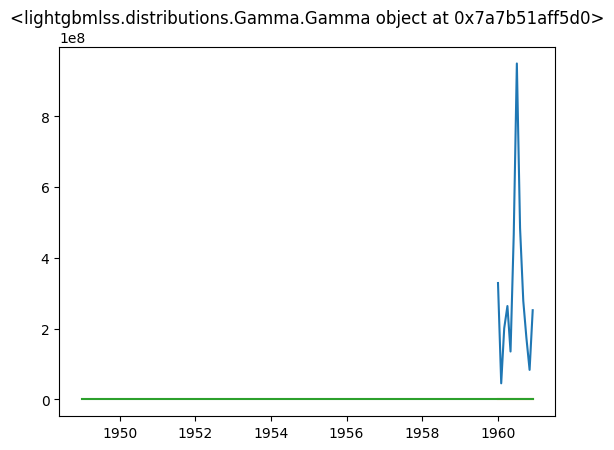

In [323]:

  plt.plot(df.ds[-12:],preds.lgbmlss.pipe(np.exp))
  plt.plot(df.ds[-12:],preds.norm_lgb)
  plt.plot(df.ds,df.y)
  plt.title(f"{str(distribution)}")
  plt.show()